In [34]:
from file_parser import *
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import sounddevice as sd

In [10]:
input = reads('../CCS_StartFiles/Assignment_2/data/input.pcm')/(2**15)
output_c = reads('../CCS_StartFiles/Assignment_2/data/output_c.pcm')/(2**15)
output_c_adpt = reads('../CCS_StartFiles/Assignment_2/data/output_c_adaptive.pcm')/(2**15)
output_asm = reads('../CCS_StartFiles/Assignment_2/data/output_asm.pcm')/(2**15)
output_asm_adpt = reads('../CCS_StartFiles/Assignment_2/data/output_asm_adaptive.pcm')/(2**15)

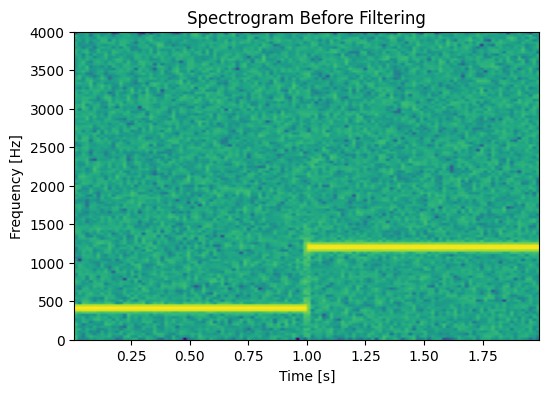

In [11]:
plt.figure(figsize=(6,4))
plt.specgram(input, Fs=8000)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram Before Filtering")
plt.show()

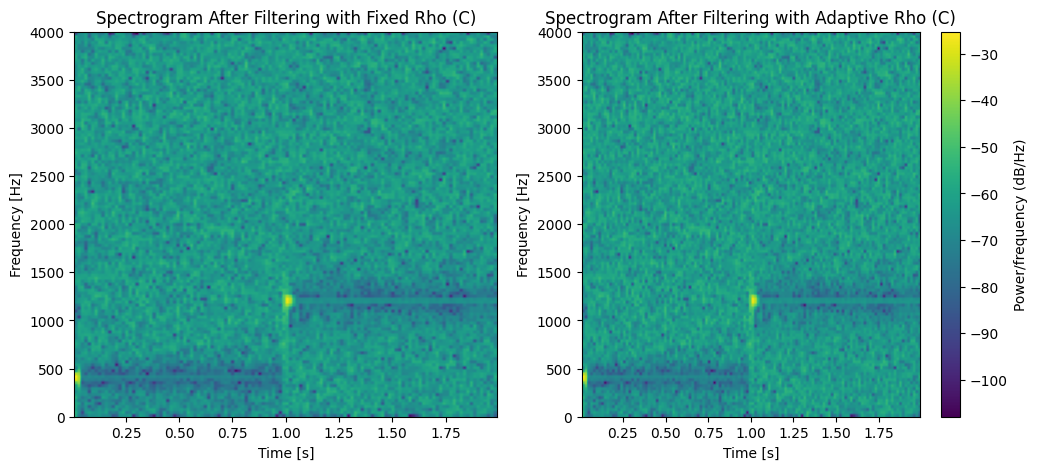

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.specgram(output_c, Fs=8000)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram After Filtering with Fixed Rho (C)")

plt.subplot(1,2,2)
plt.specgram(output_c_adpt, Fs=8000)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram After Filtering with Adaptive Rho (C)")

plt.colorbar().set_label("Power/frequency (dB/Hz)")
plt.show()

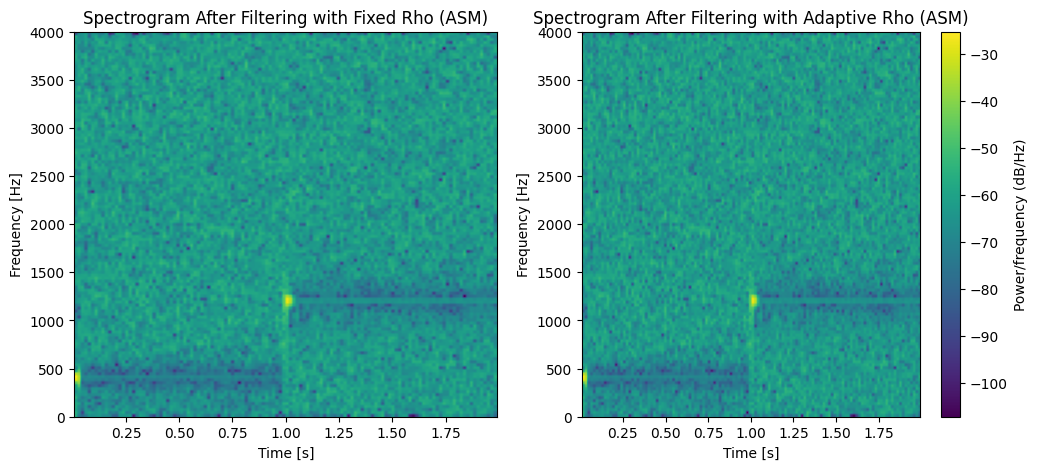

In [13]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.specgram(output_asm, Fs=8000)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram After Filtering with Fixed Rho (ASM)")

plt.subplot(1,2,2)
plt.specgram(output_asm_adpt, Fs=8000)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Spectrogram After Filtering with Adaptive Rho (ASM)")

plt.colorbar().set_label("Power/frequency (dB/Hz)")
plt.show()

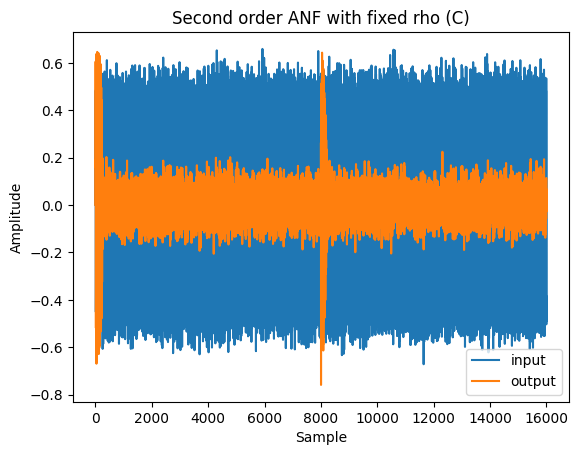

In [14]:
plt.figure()
plt.plot(input)
plt.plot(output_c)
plt.title('Second order ANF with fixed rho (C)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend(['input', 'output'])

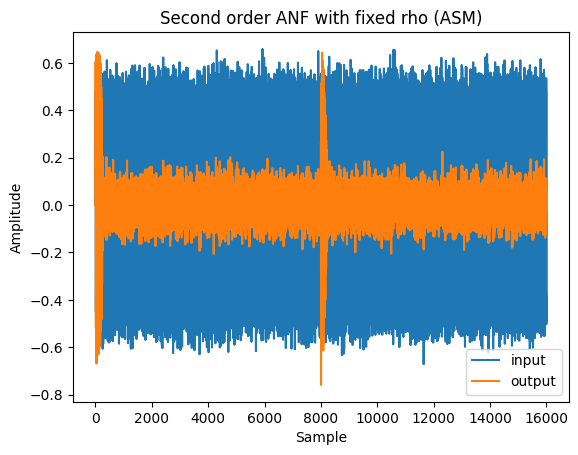

In [15]:
plt.figure()
plt.plot(input)
plt.plot(output_asm)
plt.title('Second order ANF with fixed rho (ASM)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend(['input', 'output'])



TESTING

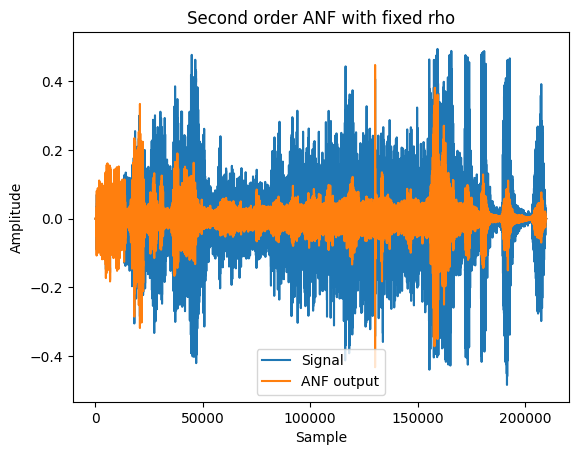

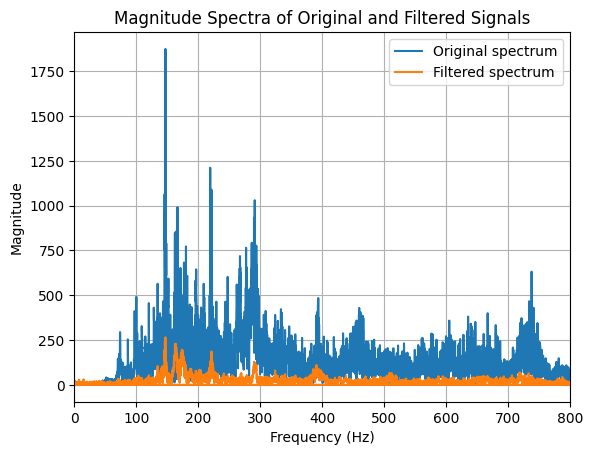

Playing original audio...
Playing filtered audio...


In [68]:
audio_file = "audio/NoisyVoice.wav"
audio_data, fs = sf.read(audio_file)
signal = 0.5*audio_data[:, 0] #select the left channel
# change the amplitude to fit in constraints
# for single channel inputs remove channel selection
N = len(signal) #number of samples in signal


# Initializations
e = np.zeros(N)  # ANF output signal vector
s = np.zeros(3)  # ANF state vector
a = np.zeros(N)  # ANF coefficient vector (for debugging only)

a_i = 1  # initialization of ANF parameter
rho = 0.8  # fixed rho
mu = 2 * 100 / (2 ** 15)  # 2 * mu

# Simulation loop (iterations over time)
for i in range(N):
    s[2] = s[1]
    s[1] = s[0]
    s[0] = signal[i] + rho * a_i * s[1] - (rho ** 2) * s[2]
    e[i] = s[0] - a_i * s[1] + s[2]
    a_i = a_i + 2 * mu * s[1] * e[i]
    a[i] = a_i

# # Plot results
plt.figure()
plt.plot(signal)
plt.plot(e)
plt.title('Second order ANF with fixed rho')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend(['Signal', 'ANF output'])
plt.show()

 #Compute the FFT of the original signal
fft_result_original = np.fft.fft(signal)
fft_freq_original = np.fft.fftfreq(len(signal), 1/fs)

fft_result_filtered = np.fft.fft(e)
fft_freq_filtered = np.fft.fftfreq(len(e), 1/fs)

magnitude_original = np.abs(fft_result_original)
magnitude_filtered = np.abs(fft_result_filtered)

plt.figure()
plt.plot(fft_freq_original, magnitude_original)
plt.plot(fft_freq_filtered, magnitude_filtered)
plt.title("Magnitude Spectra of Original and Filtered Signals")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.xlim(0, 800)
plt.legend(['Original spectrum', 'Filtered spectrum'])
plt.show()


# Normalize the filtered signal for playback
e_normalized = e / np.max(np.abs(e))

# Play the original audio
print("Playing original audio...")
sd.play(signal, samplerate=fs)
sd.wait()  # Wait until the playback is done

# Play the filtered audio
print("Playing filtered audio...")
sd.play(e_normalized, samplerate=fs)
sd.wait()  # Wait until the playback is done